# Pricing Heating Degree Days (HDD) Derivatives

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy import stats, interpolate
from scipy.optimize import curve_fit
from statsmodels.tsa.ar_model import AutoReg
from scipy.optimize import newton

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Background

### Temperature Dynamics

Since temperature is non-tradable, the market price of risk should be accounted for in the pricing model in order to obtain unique prices for the contracts. In this notebook the pricing is carried out under the parametric risk neutral probability $\mathbb{Q}^\lambda$, where $\lambda$ is a constant market price of risk.\
Let $W = (W_t, t \geq 0)$ be a $\mathbb{Q}$-standard Wiener process, then the DAT given by the following OU process
\begin{equation}
dT_t = \left(\frac{d\theta_t}{dt} + \kappa(\theta_t - T_t) - \lambda\sigma_t \right)dt + \sigma_t dW^{\mathbb{Q}}_t
\end{equation}

an explicit solution is given by (Proof available upon request)
\begin{equation}
 T_t = \theta_t + e^{-\kappa(t - s)}(T_s - \theta_s) - \lambda\int_{s}^{t}\sigma_u e^{-\kappa(t - u)}du
    + \int_{s}^{t}\sigma_u e^{-\kappa(t - u)}dB_u
\end{equation}
Therefore
$$
\mathbb{E}^\mathbb{Q}[T_t|\mathcal{F}_s]  = \mathbb{E}^\mathbb{P}[T_t|\mathcal{F}_s] - \lambda\int_{s}^{t}\sigma_u e^{-\kappa(t - u)}du
$$
$$
\mathbb{V}ar^\mathbb{Q}[T_t|\mathcal{F}_s]  = \int_{s}^{t}\sigma_u^2 e^{-2\kappa(t - u)}dB_u
$$
Additionally, as long as volatility $\sigma_i \forall i \in [s, t]$ is constant throughout the interval $[s, t]$, the expectation, variance, and covariance are given by 
$$
\mathbb{E}^\mathbb{Q}[T_t|\mathcal{F}_s] = \mathbb{E}^\mathbb{P}[T_t|\mathcal{F}_s] - \frac{\lambda\sigma_i}{\kappa}(1 - e^{-\kappa(t - s)})
$$
$$
\mathbb{V}ar^\mathbb{Q}[T_t|\mathcal{F}_s]  = \frac{\sigma_i^2}{2\kappa}(1 - e^{-2\kappa(t - s)})
$$
$$
\mathbb{C}ov^\mathbb{Q}[T_t, T_u|\mathcal{F}_s]  = e^{-\kappa(u - t)}\mathbb{V}ar^\mathbb{Q}[T_t|\mathcal{F}_s]
$$
where $0\leq s\leq t \leq u$

### Payoff and Pricing

For a given strip or season, the payoff of a HDD index is given by
\begin{equation}
\phi = \alpha(HDD_n - K)^+
\end{equation}
where $\alpha$ is the tick size, $K$ is the strike, and
$$
HDD_n = \sum_{n = 1}^{N}\operatorname{max}(0, T_{ref} - DAT_n)
$$
where $T_{ref}$ is a reference temperature, such as 18°C for contracts traded in the CME.\
under the risk neutral $\mathbb{Q}$-measure conditional on in formation at time $s$
$$
T_t \sim \mathcal{N}(\mu_t, \sigma_t^2)
$$
where $\mu_t = \mathbb{E}^\mathbb{Q}[T_t|\mathcal{F}_s]$ and $\sigma_t^2 = \mathbb{V}ar^\mathbb{Q}[T_t|\mathcal{F}_s]$. When working on Dutch data, it was found that winter periods in the Netherlands satisfy the following
$$
\mathbb{P}[max(0, 18 - DAT_n) = 0] \approx 0
$$
Hence, for Dutch HDD contracts, we have that
$$
HDD_n = 18n - \sum_{i = 1}^{n}T_{t_i};
$$
Since $T_{t_i}$ come from a normally distributed OU process, it holds that $[T_{t_1}, T_{t_2}, \cdots, T_{t_n}]$ is also normally distributed. Therefore, $HDD_n$ is also Gaussian with mean
$$
\mathbb{E}^\mathbb{Q}[HDD_n|\mathcal{F}_t] = \mathbb{E}^\mathbb{Q}\Biggr[18n - \sum_{i = 1}^{n}T_{t_i}|\mathcal{F}_t\Biggr] = 18n - \sum_{i = 1}^{n}T_{t_i}\mathbb{E}^\mathbb{Q}[T_{t_i}|\mathcal{F}_t]
$$
and variance
$$
\mathbb{V}ar^\mathbb{Q}[HDD_n|\mathcal{F}_t] = \sum_{i = 1}^{n}T_{t_i}\mathbb{V}ar^\mathbb{Q}[T_{t_i}|\mathcal{F}_t] + 2\mathop{\sum\sum}_{i<j}\mathbb{C}ov[T_{t_i}, T_{t_j}|\mathcal{F}_t]
$$
According to the fundamental theorem of asset pricing, the absence of arbitrage, i.e. under an equivalent martingale measure, implies the existence of a state price density which in turn implies the existence of risk neutral probabilities, therefore the price of a HDD call option at time $t \leq t_1$ is

\begin{align}
    \begin{split}
    C_{HDD}(t) & = e^{-r(t_n - t)}\mathbb{E}^\mathbb{Q}[\alpha\operatorname{max}\{HDD_n - K, 0\}|\mathcal{F}_t]\\
    & = e^{-r(t_n - t)}\int_{K}^{\infty}(x - k)f_{HDD_n}(x)dx\\
    & = e^{-r(t_n - t)}\Biggl( (\mu_n - K)\Phi(-\xi_n) + \frac{\sigma_n}{\sqrt{2\pi}}e^{-\frac{\xi_n^2}{2}} \Biggl)
    \end{split}
\end{align}
where $e^{-r(t_n - t)}$ is a stochastic discount factor, $K$ is the strike, $\xi_n = (K - \mu_n) / \sigma_n$, and $\Phi$ is the cumulative distribution function of the standard normal distribution. Similarly, the price of a HDD put option at time $t \leq t_1$ is
\begin{align}\label{put}
    \begin{split}
        P_{HDD}(t) & = e^{-r(t_n - t)}\mathbb{E}^\mathbb{Q}[\alpha \operatorname{max}\{K - HDD_n, 0\}|\mathcal{F}_t]\\
        & = e^{-r(t_n - t)}\int_{0}^{K}(K-x)f_{HDD_n}(x)dx\\
        & = e^{-r(t_n - t)}\Biggr[(K - \mu_n)\Biggl(\Phi(\xi_n) - \Phi\Bigl(-\frac{\mu_n}{\sigma_n}\Bigl)\Biggl) + \frac{\sigma_n}{\sqrt{2\pi}}\Bigl(e^{-\frac{\xi_n^2}{2}} - e^{\frac{1}{2}(\frac{\mu_n}{\sigma_n})^2}\Bigl)\Biggr]
    \end{split}
\end{align}

## Market Price of Risk 

The market price of risk $\lambda$ represents the risk preferences of market participants and their willingness to expose themselves to risk. Previous studies commonly assumed a market price of risk of zero, whereas recent research indicates the opposite. The approach commonly used in the literature suggests inferring the market price of risk from market data. That is, finding the value of $\lambda$ that matches theoretical model prices with observed market prices. Although it assumes, that $\lambda$ is constant, subsequent research indicates the opposite. For instance, some studies, compare the theoretical future prices to the prices observed in the market under the assumption of a Lévy process, and examines the time dependence of the market price of risk and finds a relationship between $\lambda_t$ and its lag. Other studies that estimate the implied market price of risk for German CAT derivatives in Berlin find a non-zero value of $\lambda$ with an increasing seasonal structure as the expiration date of the temperature future increases.\
In a new approach, I propose to break away from the frameworks in the literature and assume a time varying $\lambda$, i.e $\lambda = \lambda_t$. Since the market price of risk can be inferred from market data then $\lambda_t$ can be estimated using a root finding algorithm. That is, focusing on puts, the market price of risk for a given option is the $\lambda$-value for which
\begin{equation}
    V_p(t_0, HDD, K, T, r, \lambda) = V_p^{mkt}(K,T)
\end{equation}
where $V_p(t_0, HDD, K, T, r, \lambda)$ is the predicted put price, $V_p^{mkt}(K,T)$ is the observed market price of the put, and $t_0 = 0$.\
To find $\lambda_t$ the Newton Raphson root-finding iteration can be used such that
\begin{equation}
    f(\lambda) := V_p^{mkt}(K,T) - V_p(t_0, HDD, K, T, r, \lambda) = 0
\end{equation}
Hence, since $\lambda_t$ is not constant, given an initial guess $\lambda_t^0$ and $\frac{df(\lambda)}{d\lambda}$ the next approximations of $\lambda_t^i$ are found as
$$
\lambda_t^{i+1} = \lambda_t^i - \frac{f(\lambda_t^i)}{f'(\lambda_t^i)};\quad \forall i \geq 0
$$

## Code Example

### Temperature visualization

In [23]:
amsterdam = pd.read_csv('/AmstImproved2.csv', parse_dates = ['date'], index_col = [0])

In [5]:
amst_avg = amsterdam[['Average Temperature']].copy(deep = True)
amstc = amsterdam[['Average Temperature']].copy(deep = True)
amst_szn = amsterdam.copy(deep = True)

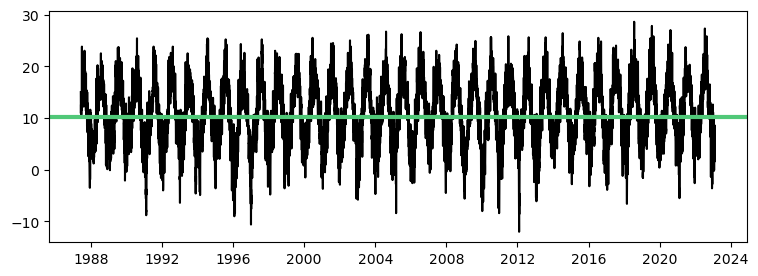

In [6]:
fig = plt.figure(figsize = (9, 3))
plt.plot(amsterdam['Average Temperature'][6000:], color = 'k')
plt.axhline(amsterdam['Average Temperature'].mean(), linewidth = 3, color = '#50C878')

In [7]:
amst_szn['month'] = amst_szn.index.month
amst_split = (amst_szn['month'] >= 5) & (amst_szn['month'] <= 10)
amst_szn['summer'] = np.where(amst_split, 1, 0)
amst_szn['winter'] = np.where(amst_szn['summer'] != 1, 1, 0)

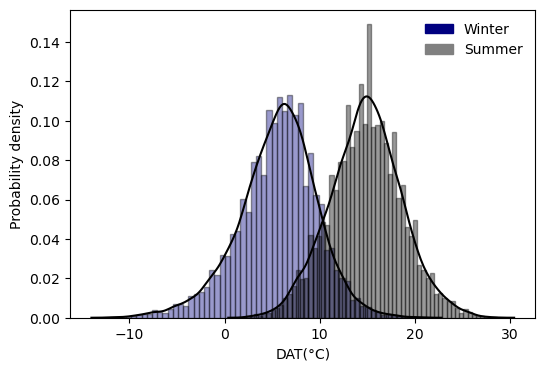

In [8]:
fig ,ax = plt.subplots(figsize = (6, 4))

sns.distplot(amst_szn[amst_szn['winter'] == 1]['Average Temperature'], bins = 60,
             hist_kws = {'color': 'navy', 'edgecolor': 'black'},
            kde_kws = {'color': 'black', 'linewidth': 1.5})
sns.distplot(amst_szn[amst_szn['summer'] == 1]['Average Temperature'], bins = 60, 
            hist_kws = {'color': 'black', 'edgecolor': 'black'},
            kde_kws = {'color': 'black', 'linewidth': 1.5})

black = mpatches.Patch(color = 'navy', label = 'Winter')
grey = mpatches.Patch(color = 'grey', label = 'Summer')

ax.legend(handles = [black, grey], frameon = False)

ax.set_xlabel('DAT(°C)')
ax.set_ylabel('Probability density')

plt.show()

### Pricing

#### Defining helper functions

The annual cycle or seasonal mean of the DAT can be captured by the first order Fourier series of a sinusoid of the form 
$$
    \theta_t = A + Bt + C\sin{(\omega t + \varphi)} \quad \forall t\in \mathbb{N}
$$
where $\omega \approx 2\pi/365.25$, $\varphi$ is a phase shift that calibrates the sinusoid for the fact that maximum and minimum temperatures do not occur on the first of January and the first of July, respectively, and $A$ is the amplitude of the sinusoid, i.e. the peak deviation of the function from its center position, which should be chosen alongside $B$, and $C$ so that the curve fits the data.

In [9]:
def temperature(x, a, b, c, varphi):
    omega = 2 * np.pi / 365.25
    y_hat = a + b * x + c * np.sin(omega * x + varphi)
    return y_hat

We showed that the DAT is given by an OU process that incorporates the term $d\theta_t/dt$. The reason is that modeling the mean reversion by this by the time-varying term given by 
$$
\frac{d\theta_t}{dt} = B + \omega C\cos(\omega t + \varphi)
$$
adjusts the drift in the SDE.

In [10]:
def temperature_derivative(x, a, b, c, varphi):
    omega = 2 * np.pi / 365.25
    derivative = b + c * omega * np.cos(omega * x + varphi)
    return derivative

It was also found in a larger study carried out by the author that the following function works best for approximating volatility

In [11]:
def volatility_model(k, indep, dep):
    indep_prime = np.linspace(0, 1, k + 2)[1: - 1]
    knot, coeff, degree = interpolate.splrep(indep, dep, t = np.quantile(indep, indep_prime))
    dep_fit = interpolate.BSpline(knot, coeff, degree)(indep)
    return dep_fit

By solving for $\theta_t$ it was found that in Amsterdam
$$
\theta_t = 9.22 + 1.07\text{e-}4t + 7.31\sin{(\omega t - 1.95)}
$$

In [12]:
def coefficients(x, parameters):
    a, b, a1, b1 = parameters
    omega = 2 * np.pi / 365.25
    varphi = np.arctan(a1 / b1) - np.pi
    c = np.sqrt( (a1 ** 2) + (b1 ** 2))
    print('Amsterdam Parameters:\n a {0:0.3}\n b {1:.2e}\n c {2:0.3}\n varphi {3:0.3}'.format(a, b, c, varphi))
    y_hat = a + b * x + c * np.sin(omega * x + varphi)
    return y_hat
def coefficients_fit(x, a, b, a1, b1):
    omega = np.pi * 2 / 365.25
    y_pred = a + b * x + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    return y_pred

In [13]:
amst_ord = amst_avg.index.map(dt.datetime.toordinal)[0]
amst_avg.index = amst_avg.index.map(dt.datetime.toordinal)

In [14]:
x, y = curve_fit(coefficients_fit, xdata = amst_avg.index - amst_ord,
                 ydata = amst_avg['Average Temperature'], method = 'lm')
amst_avg['Model'] = coefficients(amst_avg.index - amst_ord, x)

Amsterdam Parameters:
 a 9.22
 b 1.07e-04
 c 7.31
 varphi -1.95


We also find that the speed of mean reversion $\kappa = 0.206$ 

In [15]:
amst_avg.idnex = amst_avg.index.map(dt.datetime.fromordinal)
amst_avg['residual'] = amst_avg['Average Temperature'] - amst_avg['Model']

amst_res = amst_avg['residual']
amst_res.index = amst_res.index
amst_res.index = pd.DatetimeIndex(amst_res.index).to_period('D')

amst_model = AutoReg(amst_res, lags = 1, old_names = True, trend = 'n')
amst_model_fit = amst_model.fit()
amst_params = amst_model_fit.params
amst_res = amst_model_fit.resid
amst_gamma = amst_params[0]
amst_kapa = 1 - amst_gamma

In [16]:
amst_kapa

0.20581285751037082

#### Putting everything together

In [17]:
amst_params = [9.27, 1.05e-4, 7.21, -1.96]
amst_first_ord = amstc.index.map(dt.datetime.toordinal)[0]
amst_vol = amsterdam['Average Temperature'].copy(deep = True).to_frame()
amst_vol['day'] = amst_vol.index.dayofyear
amst_vol['month'] = amst_vol.index.month
vol = amst_vol.groupby(['day'])['Average Temperature'].agg(['mean', 'std'])
days = np.array(vol['std'].index)
amst_std = np.array(vol['std'].values)
amst_volatility = volatility_model(20, days, amst_std)

In [18]:
def expectation(seasonal, vol, time, lmd, kappa):
    grid = 1 / 365.25
    n = len(time)
    second_term = - vol * (1 - np.exp(- kappa * grid)) / kappa
    mean = 18 * n - (np.sum(seasonal) - lmd * np.sum(second_term))
    return mean

def variance(vol, time, kappa):
    grid = 1 / 365.25
    var = np.power(vol, 2)
    first_term = var / (2 * kappa) * (1 - np.exp(- 2 * kappa * grid))
    cov = 0
    for y, ty in enumerate(time):
        for z, tz in enumerate(time):
            if z > y:
                cov += np.exp(- kappa * (tz - ty)) * var[y]
    return np.sum(var) + 2 * cov

def price(dates, seasonal_params, vol_model, amst_first_ord, lmd, kappa = 0.211):
    if isinstance(dates, pd.DatetimeIndex):
        date = dates.map(dt.datetime.toordinal)
    seasonals = temperature(date - amst_first_ord, * amst_params)
    seasonals_derivative = temperature_derivative(date - amst_first_ord, * amst_params)
    amst_temps = pd.DataFrame(data = np.array([seasonals, seasonals_derivative]).T,
                         index = dates, columns = ['seasonal', 'seasonal_derivative'])
    amst_temps['day'] = amst_temps.index.dayofyear
    amst_temps['vol'] = vol_model[amst_temps['day'] - 1]
    amst_time = np.array([x / 365.25 for x in range(1, len(dates) + 1)])
    vol = amst_temps['vol'].values
    amst_exp = expectation(seasonals, vol, amst_time, lmd, kappa)
    amst_var = variance(vol, amst_time, kappa)
    return amst_exp, amst_var

In [19]:
strip = pd.date_range(start = '2023-11-01', end = '2024-03-31', freq = 'D')
r = 0.0275
K = 1800
alpha = 1

def years(i_1, i_2):
    i_1 = dt.datetime.strptime(i_1, '%Y-%m-%d')
    i_2 = dt.datetime.strptime(i_2, '%Y-%m-%d')
    return abs((i_2 - i_1).days)/365.25

start = '2023-06-18' #dt.datetime.today().strftime('%Y-%m-%d')
end = '2024-03-31'

tau = years(start, end)

print('Valuation start date:', start, '\nValuation end date:', end, '\nTime to maturity in years:', round(tau, 3))

Valuation start date: 2023-06-18 
Valuation end date: 2024-03-31 
Time to maturity in years: 0.786


#### Assuming the market price of risk is 0 (Pricing using an approximation of the market price of risk $\lambda$ is available upon request)

In [20]:
def option(dates, r, alpha, K, tau, option = 'call', lmd = 0):
    amst_exp, amst_var = price(dates, amst_params, amst_volatility, amst_first_ord, lmd)
    discount = np.exp(-r*tau)
    amst_vol = np.sqrt(amst_var)
    xi = (K - amst_exp)/amst_vol
    exponential = np.exp(-xi**2/2)
    if option == 'call':
        predicted_price = alpha*discount*((amst_exp - K)*stats.norm.cdf(-xi) + amst_vol*exponential/np.sqrt(2*np.pi))
    elif option == 'put':
        exponential2 = np.exp(-amst_exp**2/(2*amst_vol**2))
        predicted_price = alpha*discount*((K - amst_exp)*(stats.norm.cdf(xi) - stats.norm.cdf(-amst_exp/amst_vol)) +
                                           amst_vol/np.sqrt(2*np.pi)*(exponential-exponential2))
        
    print('The option price is:', predicted_price)

In [21]:
option(strip, r, alpha, K, tau, 'put')

The option price is: 202.07947132828403
